In [1]:
# 環境構築

!apt-get update
!apt-get install -y libsndfile1-dev
!pip install scipy
!pip install scikit-learn
!pip install librosa

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease      
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2069 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [28.5 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1937 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.2 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2972 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1299 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [55.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [28.6 kB]
Get:13 http:

Setting up libsndfile1:amd64 (1.0.28-7ubuntu0.1) ...
Setting up libxml2:amd64 (2.9.10+dfsg-5ubuntu0.20.04.5) ...
Setting up libvorbis-dev:amd64 (1.3.6-2ubuntu1) ...
Setting up libsndfile1-dev (1.0.28-7ubuntu0.1) ...
Setting up shared-mime-info (1.15-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
     |████████████████████████████████| 34.5 MB 16.1 MB/s eta 0:00:01     |████████████████████████▌       | 26.4 MB 17.6 MB/s eta 0:00:01     |██████████████████████████      | 28.1 MB 17.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.8 MB 114 kB/s eta 0:00:01     |████████████████████████████▎   | 8.6 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 9.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 252 kB 49 kB/s  eta 0:00:01
     |█████████████

In [1]:
# clips 作成

SAMPLING_RATE = 44100 # 変更不可

clip_size = 81920 # 楽曲を再構築するパーツ1つあたりの大きさ
window_size = 10240 # CQT_CHROMA を取得するのに使用するサンプル数
hop_size = 640 # window をずらすときの大きさ

from scipy.io.wavfile import read, write
import glob
import os
import numpy as np
import librosa
import sys

if os.path.isfile("../data/out/clips.wav"):
    print("../data/out/clips.wav exists.")
    files = ["../data/out/clips.wav"]
else:
    # clips.npy をもとにデータを作成する 
    if os.path.isfile("../data/arrays/clips.npy"):
        print("loading ../data/arrays/clips.npy ...")
        clips = np.load("../data/arrays/clips.npy")
        print("creating ../data/out/clips.wav ...")
        write("../data/out/clips.wav", SAMPLING_RATE, clips.reshape((clips.shape[0] * clips.shape[1], )))
        files = ["../data/out/clips.wav"]
        
    # clips,npy がないとき /data/wav44100 内の WAV ファイルを参照する
    else:
        files = glob.glob("../data/wav44100/*.wav")
        #files = ["../data/wav44100/3DEmbodimentFromLines.wav"] # デバッグ用 
        
if len(files) == 0:
    print("WAV ファイルが見つかりませんでした。")
    sys.exit(1)
        
clips_filename = "../data/arrays/c" + str(clip_size) + "_f32_clips"

if os.path.isfile(clips_filename + ".npy"):
    print("loading " + clips_filename + ".npy ...")
    clips = np.load(clips_filename + ".npy")
else:
    print("creating " + clips_filename + ".npy ...")
    raw_data_list = [librosa.load(file, sr=SAMPLING_RATE)[0] for file in files] # 左の音だけ使う

    clips = np.zeros((0, clip_size), dtype=np.float32)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, clip_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save(clips_filename, clips)

print("The clip array has " + str(clips.shape[0]) + " clips.")

../data/out/clips.wav exists.
loading ../data/arrays/c81920_f32_clips.npy ...
The clip array has 14260 clips.


In [2]:
# cqt 作成

n_bins = 84

cqt_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqts"

if os.path.isfile(cqt_filename + ".npy"):
    print("loading " + cqt_filename + ".npy ...")
    cqts = np.load(cqt_filename + ".npy")
else:
    print("creating " + cqt_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("cqt progress: clip " + str(num + 1) + " / " + str(len(clips)))
        
        tmp_cqt = librosa.cqt(clip, sr=SAMPLING_RATE, hop_length=hop_size, n_bins=n_bins)
        tmp_cqt = tmp_cqt.reshape((1, tmp_cqt.shape[0], tmp_cqt.shape[1]))
        
        if num == 0:
            cqts = tmp_cqt
        else:
            cqts = np.vstack((cqts, tmp_cqt))
            
        num += 1

    np.save(cqt_filename, cqts)
    
print("The cqt array has " + str(cqts.shape[0]) + " cqts.")
print("cqts.shape: " + str(cqts.shape))
print("Type(cqts[0][0][0]): " + str(type(cqts[0][0][0])))
print("np.max(cqts[0][0]): " + str(np.max(cqts[0][0])))

loading ../data/arrays/c81920_f32_clips_w10240_h640_cqts.npy ...
The cqt array has 14260 cqts.
cqts.shape: (14260, 84, 129)
Type(cqts[0][0][0]): <class 'numpy.complex64'>
np.max(cqts[0][0]): (0.021538047+0.007131239j)


In [3]:
# cqt_choroma 作成

def Preprocessing(array):
    array = np.abs(array)
    array = np.log(array + 1)
    array = array / np.log(np.finfo(np.float32).max)
    array = array.T
    return array

cqt_chroma_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqt_chromas"

if os.path.isfile(cqt_chroma_filename + ".npy"):
    print("loading " + cqt_chroma_filename + ".npy ...")
    cqt_chromas= np.load(cqt_chroma_filename + ".npy")
else:
    print("creating " + cqt_chroma_filename + ".npy ...")
    num = 0
    for cqt in cqts:
        print("cqt_chroma progress: clip " + str(num + 1) + " / " + str(len(cqts)))
        
        tmp_cqt_chroma = librosa.feature.chroma_cqt(C=cqt, sr=SAMPLING_RATE)
        tmp_cqt_chroma = Preprocessing(tmp_cqt_chroma)
        tmp_cqt_chroma = tmp_cqt_chroma.reshape((1, tmp_cqt_chroma.shape[0], tmp_cqt_chroma.shape[1]))
        
        if (num == 0):
            cqt_chromas = tmp_cqt_chroma
        else:
            cqt_chromas = np.vstack((cqt_chromas, tmp_cqt_chroma))
            
        num += 1

    np.save(cqt_chroma_filename, cqt_chromas)
    
print("The cqt_chroma array has " + str(cqt_chromas.shape[0]) + " cqt_chromas.")
print("cqt_chromas.shape: " + str(cqt_chromas.shape)) # clip 番号、window 番号、 chroma 番号 になる
print("Type(cqt_chromas[0][0][0]): " + str(type(cqt_chromas[0][0][0])))
print("np.max(cqt_chromas[0][0]): " + str(np.max(cqt_chromas[0][0])))

loading ../data/arrays/c81920_f32_clips_w10240_h640_cqt_chromas.npy ...
The cqt_chroma array has 14260 cqt_chromas.
cqt_chromas.shape: (14260, 129, 12)
Type(cqt_chromas[0][0][0]): <class 'numpy.float32'>
np.max(cqt_chromas[0][0]): 0.0078125


In [5]:
# 学習データとテストデータに分ける

def normalize(array):
    if (np.sum(array) == 0):
        return array
    else:
        return array / np.sum(array)
    
test_data_rate = 0.2
window_num_per_clip = cqt_chromas.shape[1]

cqt_chroma_sum_threshold = 0.01 # 次の window の sum が閾値に満たないときに除外します

cqt_chromas = np.concatenate([cqt_chromas[:-1, :, :], cqt_chromas[1:, 0, :].reshape(cqt_chromas.shape[0] - 1, 1, cqt_chromas.shape[2])], 1)

clips = np.delete(clips, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)
cqt_chromas = np.delete(cqt_chromas, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)

p = np.random.permutation(len(cqt_chromas))
cqt_chromas = cqt_chromas[p]
clips = clips[p]

x_test = cqt_chromas[:int(cqt_chromas.shape[0] * test_data_rate), :window_num_per_clip, :].reshape(int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, 12, 1)
x_train = cqt_chromas[int(cqt_chromas.shape[0] * test_data_rate):, :window_num_per_clip, :].reshape(cqt_chromas.shape[0] - int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, 12, 1)
y_test =  np.apply_along_axis(normalize, 1, cqt_chromas[:int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, :])
y_train = np.apply_along_axis(normalize, 1, cqt_chromas[int(cqt_chromas.shape[0] * test_data_rate):, window_num_per_clip, :])

print("x_train.shape: " + str(x_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))

x_train.shape: (10967, 130, 12, 1)
x_test.shape: (2741, 130, 12, 1)
y_train.shape: (10967, 12)
y_test.shape: (2741, 12)


In [6]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
# モデル作成

chroma_size = cqt_chromas.shape[2]

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input, MaxPooling2D
from keras.optimizers import Adam

learning_rate = 0.0001
 
model = keras.models.Sequential()
model.add(Conv2D(32, (3, 1), activation="relu", input_shape=(window_num_per_clip, chroma_size, 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=chroma_size))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 12, 32)       128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 12, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 12, 64)        6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 12, 64)        0

In [8]:
# 学習
batch_size = 64
epochs = 100
model_name = "cqt_chroma_batch" + str(batch_size) + "_e" + str(epochs)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("../data/models/" + model_name)

Epoch 1/5
172/172 [==============================] - 11s 58ms/step - loss: 2.4781 - accuracy: 0.1456 - val_loss: 2.4770 - val_accuracy: 0.1507
Epoch 2/5
172/172 [==============================] - 10s 57ms/step - loss: 2.4768 - accuracy: 0.1493 - val_loss: 2.4774 - val_accuracy: 0.1507
Epoch 3/5
172/172 [==============================] - 10s 56ms/step - loss: 2.4769 - accuracy: 0.1493 - val_loss: 2.4766 - val_accuracy: 0.1507
Epoch 4/5
172/172 [==============================] - 10s 57ms/step - loss: 2.4768 - accuracy: 0.1493 - val_loss: 2.4774 - val_accuracy: 0.1507
Epoch 5/5
172/172 [==============================] - 10s 58ms/step - loss: 2.4768 - accuracy: 0.1493 - val_loss: 2.4779 - val_accuracy: 0.1507


INFO:tensorflow:Assets written to: ../data/models/cqt_chroma_batch64_e5/assets


INFO:tensorflow:Assets written to: ../data/models/cqt_chroma_batch64_e5/assets


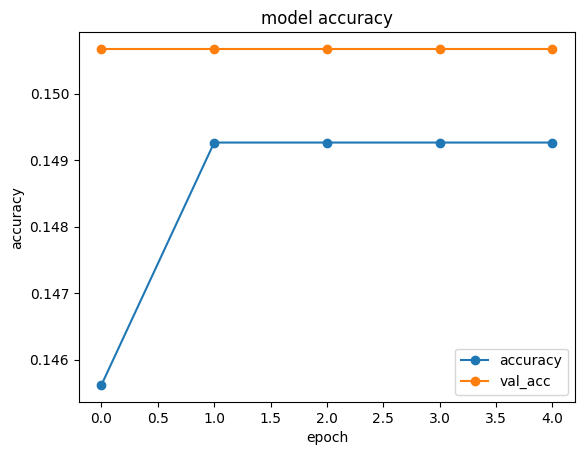

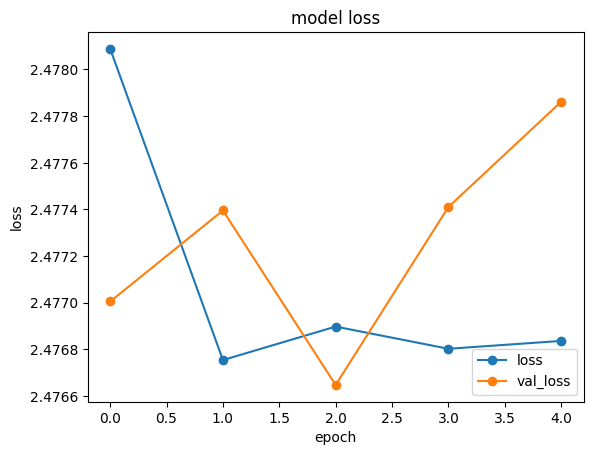

In [9]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [10]:
# 楽曲の出力

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
import soundfile as sf

model = load_model("../data/models/" + model_name)
file_name = "out_" + model_name
length = 10

def create_music(fname):
    first_index = np.random.randint(0, len(x_test))
    predict_index = first_index

    for i in range(length):
        print("-- generate " + str(i + 1) + " / " + str(length))
        predict = model.predict(np.array([x_test[predict_index]]))

        index = 0
        similar_index = 0
        cos_sim = -1
        for cqt_chroma in x_test[:, 0:1, :, 0]:
            tmp_sim = cosine_similarity(predict, cqt_chroma) 
            if tmp_sim > cos_sim:
                cos_sim = tmp_sim
                similar_index = index
            index += 1

        print("cos_sim: " + str(cos_sim))
        print("predict: " + str(predict))
        print("x_test[similar_index]: " + str(x_test[similar_index, 0, :, 0]))
        print("similar_index: " + str(similar_index))
        print("--")

        predict_index = similar_index

        if i == 0:
            out = clips[predict_index]
        else:
            out = np.hstack((out, clips[predict_index]))
    
    sf.write(fname, out, SAMPLING_RATE, subtype="PCM_16")

fname = "../data/out/" + file_name + "_1.wav"
print("creating " + fname + " ...")
create_music(fname)

fname = "../data/out/" + file_name + "_2.wav"
print("creating " + fname + " ...")
create_music(fname)

fname = "../data/out/" + file_name + "_3.wav"
print("creating " + fname + " ...")
create_music(fname)

creating ../data/out/out_cqt_chroma_batch64_e5_1.wav ...
-- generate 1 / 10
1/1 [==============================] - 0s 68ms/step
cos_sim: [[0.9273567]]
predict: [[0.08628944 0.09311633 0.08947834 0.08608092 0.08312737 0.08073191
  0.08534866 0.08630007 0.07444628 0.07084871 0.07872488 0.08550709]]
x_test[similar_index]: [0.00636017 0.00605034 0.0078125  0.00466573 0.00177872 0.00418048
 0.00570182 0.00581569 0.00297882 0.00442058 0.         0.0052165 ]
similar_index: 2330
--
-- generate 2 / 10
1/1 [==============================] - 0s 14ms/step
cos_sim: [[0.9274869]]
predict: [[0.08623098 0.09319793 0.08960303 0.08607758 0.08310822 0.0807047
  0.08539953 0.0863104  0.07436539 0.07074153 0.07869482 0.08556588]]
x_test[similar_index]: [0.00636017 0.00605034 0.0078125  0.00466573 0.00177872 0.00418048
 0.00570182 0.00581569 0.00297882 0.00442058 0.         0.0052165 ]
similar_index: 2330
--
-- generate 3 / 10
1/1 [==============================] - 0s 14ms/step
cos_sim: [[0.9274869]]
predic

1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.9272274]]
predict: [[0.08620523 0.09290228 0.08941717 0.08602148 0.08312298 0.08078668
  0.08530949 0.08632781 0.07456616 0.07105897 0.07875274 0.08552898]]
x_test[similar_index]: [0.00636017 0.00605034 0.0078125  0.00466573 0.00177872 0.00418048
 0.00570182 0.00581569 0.00297882 0.00442058 0.         0.0052165 ]
similar_index: 2330
--
-- generate 2 / 10
1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.9274869]]
predict: [[0.08623098 0.09319793 0.08960303 0.08607758 0.08310822 0.0807047
  0.08539953 0.0863104  0.07436539 0.07074153 0.07869482 0.08556588]]
x_test[similar_index]: [0.00636017 0.00605034 0.0078125  0.00466573 0.00177872 0.00418048
 0.00570182 0.00581569 0.00297882 0.00442058 0.         0.0052165 ]
similar_index: 2330
--
-- generate 3 / 10
1/1 [==============================] - 0s 14ms/step
cos_sim: [[0.9274869]]
predict: [[0.08623098 0.09319793 0.08960303 0.08607758 0.08310822 0.0807047
  0.08